In [1]:
%matplotlib inline

In [2]:
import pystan
import kinesis as kn

In [3]:
"""Test the general cluster model with mock Hyades data + DR2 errors
"""
%matplotlib inline
import os
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords
# plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import arviz as az
import seaborn as sns
from corner import corner
# from getdist import plots, MCSamples
# project
import pystan
import gapipes as gp
import kinesis as kn
print(f"pystan v{pystan.__version__}")
np.random.seed(18324)

pystan v2.19.0.0


In [4]:
truth_T0 = dict(
    b0=[57.7, 41.2, 53.3], v0=np.array([-6.32, 45.24, 5.30]), sigmav=0.3
)

cl = kn.Cluster(**truth_T0).sample_sphere(N=150, Rmax=5).observe(cov=np.eye(3)*0.1**2)
cl_bg = kn.Cluster(v0=np.array([0,0,0]), sigmav=25, b0=truth_T0['b0'])\
        .sample_sphere(N=10, Rmax=10).observe(cov=np.eye(3)*0.1**2)
df = pd.concat((cl.members.observed.copy(), cl_bg.members.observed.copy()))

In [5]:
plt.style.use('kinesis.mplstyle')

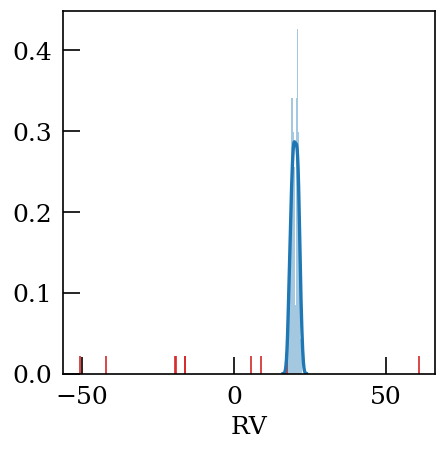

In [6]:
sns.distplot(cl.members.truth['radial_velocity'], 32, axlabel='RV');
sns.rugplot(cl_bg.members.truth['radial_velocity'], c='C3', lw=1);

In [40]:
out_full = pd.read_csv("../data/hyades_full.csv")
# %store -r out_full
df = out_full.loc[out_full['in_dr2'] == True]
print(f'{len(df)} rows')

515 rows


In [8]:
case = {}  # fit results will be saved
N=len(df)

In [10]:
df[['parallax','pmra','pmdec']]

,parallax,pmra,pmdec
0,20.904768,109.076195,-38.851480
1,21.774901,130.552061,-27.555882
2,22.734841,135.255280,-36.764306
3,23.107320,117.530976,-45.805935
4,19.976727,96.614818,-42.261540
...,...,...,...
510,19.665794,82.144634,-22.296290
511,21.830561,91.446569,-25.147918
512,20.357130,86.594066,-24.641352
513,20.769679,83.869467,-23.240592


## Simple case: T=0

In [11]:
model = kn.get_model("mixture", recompile=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f4baab562d311cbce07e3b82c356792b NOW.
INFO:kinesis.models:Compiling mixture


In [12]:
# df = cl.members.observed.copy()

rv = np.empty(0, float)
rv_error = np.empty(0, float)
irv = np.empty(0, int)
Nrv = 0

data = dict(
    N=len(df),
    ra=df["ra"].values,
    dec=df["dec"].values,
    a=df[["parallax", "pmra", "pmdec"]].values,
    C=df.g.make_cov(),
    rv=rv,
    rv_error=rv_error,
    irv=irv,
    Nrv=Nrv,
    include_T=0,
    theta=[0.5,0.5]
)

data["b0"] = np.array([0.0, 0.0, 0.0])

# TODO: init with MAP
def init():
    return {
        'd':1e3 / df["parallax"].values,
        'sigv':1.5,
        'v0':[-6.3,45,5],
        'v0_bg':[0,0,0],
        'lambda':0.1,
        'sigv_bg':50,
        'T':np.zeros(shape=(int(0), 3,3))
    }


fit = model.optimizing(data=data, init=init)

In [13]:
fit['lambda'], fit['v0'], fit['sigv'], fit['v0_bg'], fit['sigv_bg']

(array(0.99992437),
 array([-6.05025428, 45.70899683,  5.55268757]),
 array(0.37221408),
 array([-0.0004619 ,  0.00022319, -0.00012247]),
 array(30.23341719))

In [14]:
fit = model.sampling(data=data, init=init, pars=['v0', 'sigv', 'lambda', 'v0_bg', 'sigv_bg', 'probmem'])

In [15]:
from scipy.special import logsumexp

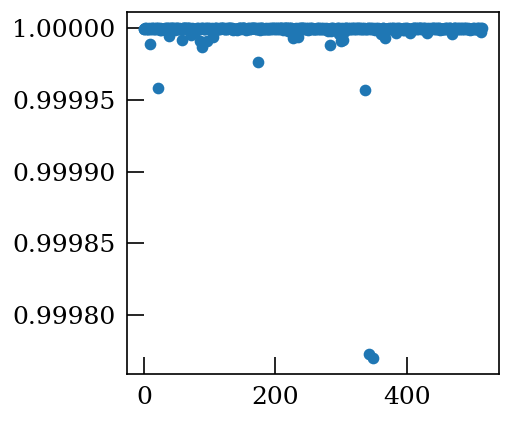

In [16]:
probmem = np.exp(fit['probmem'])
plt.plot(probmem.mean(axis=0), marker='o', ls='')

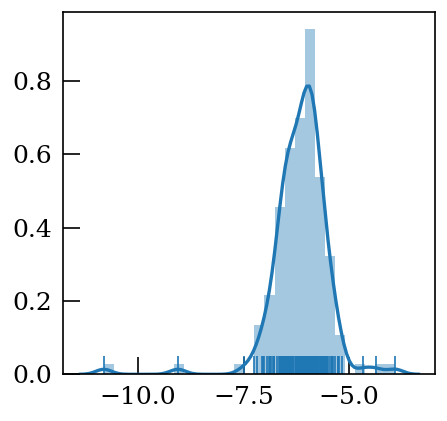

In [44]:
vx,vy,vz = df.g.icrs.velocity.d_xyz.value
sns.distplot(vx[~np.isnan(vy)], rug=True)

In [56]:
fit['lps'][:,0] < fit['lps'][:,1]

array([ True,  True,  True, ...,  True,  True,  True])

In [44]:
ll = fit['lps'] - logsumexp(fit['lps'], axis=1)[:,None]

In [30]:
np.mean(fit['v0'], axis=0)

array([-6.08196887, 45.54942893,  5.53746616])

In [18]:
azfit = az.from_pystan(fit)
az.summary(azfit, var_names=['v0','sigv','lambda','v0_bg','sigv_bg'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.049,0.053,-6.146,-5.950,0.002,0.001,857.0,857.0,861.0,1245.0,1.0
v0[1],45.713,0.123,45.473,45.937,0.004,0.003,903.0,902.0,908.0,1109.0,1.0
v0[2],5.554,0.043,5.476,5.640,0.001,0.001,924.0,924.0,930.0,1380.0,1.0
sigv,0.383,0.009,0.366,0.400,0.000,0.000,2840.0,2834.0,2846.0,2777.0,1.0
lambda,0.998,0.002,0.995,1.000,0.000,0.000,6027.0,6027.0,3986.0,2223.0,1.0
v0_bg[0],-1.071,49.898,-94.772,89.601,0.887,0.738,3162.0,2289.0,3162.0,3037.0,1.0
v0_bg[1],0.318,50.060,-100.752,90.217,0.923,0.774,2939.0,2092.0,2954.0,2784.0,1.0
v0_bg[2],-0.359,49.774,-94.003,91.271,0.825,0.760,3640.0,2143.0,3646.0,3245.0,1.0
sigv_bg,33.089,17.572,0.522,62.303,0.315,0.223,3108.0,3108.0,2342.0,1086.0,1.0


In [27]:
outlier = fit['probmem'].mean(axis=0)<0.5

In [33]:
probmem.mean(axis=0).min()

0.999770026919927

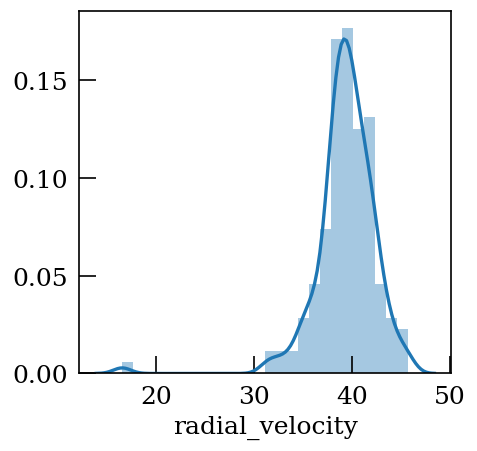

In [39]:
sns.distplot(df['radial_velocity'].dropna());

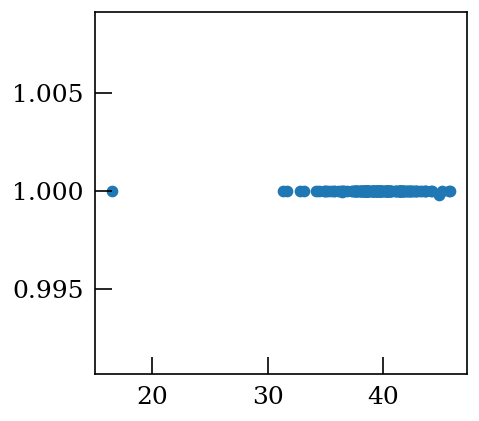

In [36]:
plt.scatter(df['radial_velocity'], probmem.mean(axis=0));

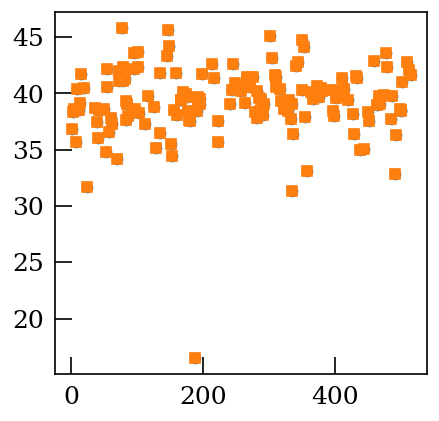

In [30]:
plt.plot(df['radial_velocity'], marker='o', ls='');
plt.plot(df['radial_velocity'][outlier], marker='s', ls='')

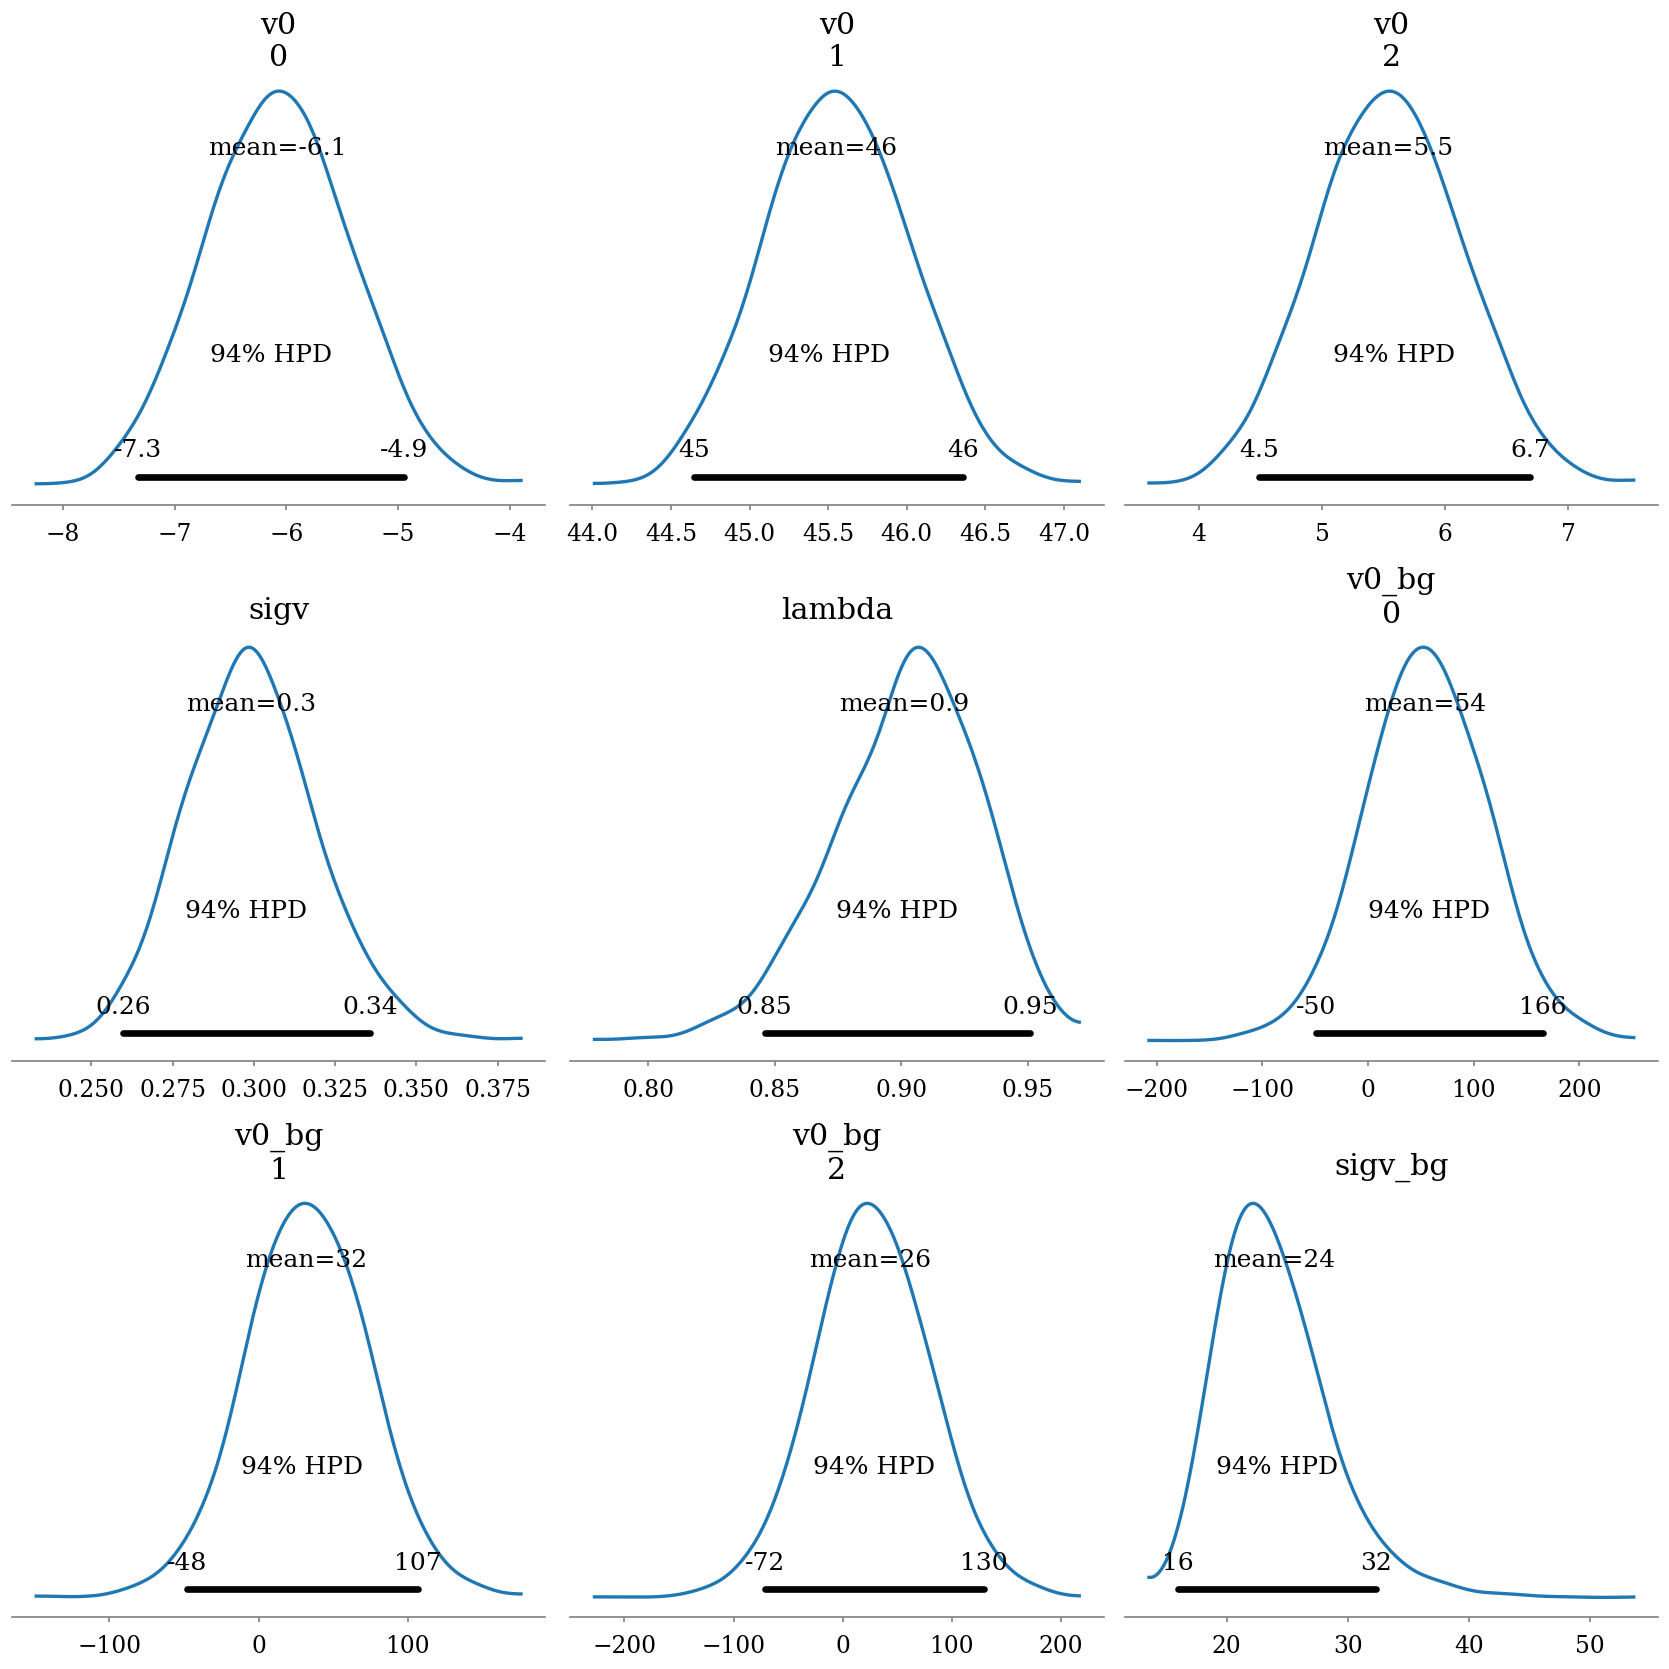

In [34]:
az.plot_posterior(azfit);

In [4]:
# if sample:
#     pars = kwargs.pop("pars", self._pars)
#     stanfit = self.model.sampling(data=data, init=init, pars=pars, **kwargs)
#     return FitResult(stanfit)
# else:
    return 

fit = fitter.fit(data, sample=False)
print(f"v0, sigv = {fit['v0']}, {fit['sigv']:.4f}")
print(f"diff from truth: {fit['v0']-truth_T0['v0']}, {fit['sigv']-truth_T0['sigmav']:.4f}")


fit = fitter.fit(data, chains=4, iter=4000)
fit.save(name)

INFO:kinesis.models:Reading model from disk


iteration 0
reading from disk
iteration 1
reading from disk
iteration 2
reading from disk
iteration 3
reading from disk
iteration 4
reading from disk
CPU times: user 651 ms, sys: 796 ms, total: 1.45 s
Wall time: 1.46 s
